In [41]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
df_bond_ratings = pd.read_csv('bond_ratings.csv', 
                              dtype={'bb_rating':str, 'us_govt_bond_rating':str, 'below_b_rating':str,
                                    'others_rating':str,'maturity_bond':str, 'b_rating':str, 'a_rating':str,
                                    'aaa_rating':str, 'aa_rating':str, 'bbb_rating':str})
df_fund_allocations = pd.read_csv('fund_allocations.csv')
df_fund_config = pd.read_csv('fund_config.csv')
df_fund_ratios = pd.read_csv('fund_ratios.csv')
df_fund_specs = pd.read_csv('fund_specs.csv', dtype={'greatstone_rating':str})
df_other_specs = pd.read_csv('other_specs.csv')
df_return_3year = pd.read_csv('return_3year.csv')
df_return_5year = pd.read_csv('return_5year.csv')
df_return_10year = pd.read_csv('return_10year.csv')
###sample submission

df_sample_submission = pd.read_csv('sample_submission.csv')

df_sample_submission.head()

,fund_id,greatstone_rating
0,85a6edf9-db47-490c-981a-168ce90434bb,NaN
1,654dac08-5e5d-4cf0-870e-3167087de7d2,NaN
2,75214019-f876-42a9-a316-328b759ac4ba,NaN
3,1fe8de6d-cd33-489e-a829-211f1f622eed,NaN
4,bd87a7a0-6ca5-4607-a0cf-d396ecd6037a,NaN


In [3]:
######## Data types adjustment for df_fund_ratios

df_fund_ratios['ps_ratio'] = df_fund_ratios['ps_ratio'].str.replace(',','')
df_fund_ratios['pc_ratio'] = df_fund_ratios['pc_ratio'].str.replace(',','')
df_fund_ratios['pe_ratio'] = df_fund_ratios['pe_ratio'].str.replace(',','')
df_fund_ratios['mmc'] = df_fund_ratios['mmc'].str.replace(',','')

df_fund_ratios.ps_ratio = df_fund_ratios.ps_ratio.astype(float)
df_fund_ratios.pc_ratio = df_fund_ratios.pc_ratio.astype(float)
df_fund_ratios.pe_ratio = df_fund_ratios.pe_ratio.astype(float)
df_fund_ratios.mmc = df_fund_ratios.mmc.astype(float)

In [ ]:
### checking if NAN values for greatstone_ranking means that its on submission sample

df_sample00 = df_root01[df_root01.greatstone_rating.isnull()][['fund_id']]
df_sample00.shape

In [ ]:
df_sample01 = pd.merge(df_sample00, df_sample_submission, how='inner', left_on='fund_id', right_on='fund_id')
df_sample01.shape

In [4]:
################# building a large dataframe ##############
#### joining tables fund specs (source of greatstone_rating) and fund_ratios (which has fund_id)
df_root01 = pd.merge(df_fund_specs, df_fund_ratios, how='left', left_on='tag', right_on='tag')

##aggregating info of ratings
df_root01 = pd.merge(df_root01, df_bond_ratings, how='left', left_on='tag', right_on='tag')

##aggretating info of allocations
df_root01 = pd.merge(df_root01, df_fund_allocations, how='left', left_on='tag', right_on='id')

##aggregating info of config
df_root01 = pd.merge(df_root01, df_fund_config, how='left', left_on='fund_id', right_on='fund_id')

##aggregating ratio info
df_other_specs.drop(['greatstone_rating','pc_ratio','pe_ratio','ps_ratio','mmc'], axis=1, inplace=True)
df_root01 = pd.merge(df_root01, df_other_specs, how='left', left_on='tag', right_on='tag')



In [8]:
df_root01.select_dtypes(include=['object']).head()

,investment_class,currency,greatstone_rating,inception_date,fund_size,fund_id,bb_rating,us_govt_bond_rating,below_b_rating,others_rating,maturity_bond,b_rating,a_rating,aaa_rating,aa_rating,bbb_rating,category,parent_company,fund_name
0,Value,USD,NaN,2015-02-02,Large,264614c6-5ac3-4146-ba26-1674b136cb40,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Energy Limited Partnership,DWS,DWS RREEF MLP & Energy Infrastructure Fund - C...
1,Growth,USD,3,2012-05-30,Large,f5ad58c2-fdea-4087-8678-e04744f89f90,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Large Growth,Janus Henderson,Janus Henderson Research Fund Class N
2,Growth,USD,4,1987-08-23,Large,3c13f4ab-02c4-4ca7-a133-7e996ec5d0c4,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Large Growth,Calvert Research and Management,Calvert Equity Fund Class A
3,Value,USD,3,2005-10-24,Large,ff78bdd8-59eb-4cef-9f3c-b1baacce9554,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Large Value,Invesco,Invesco Diversified Dividend Fund R5 Class
4,Blend,USD,0,2016-12-12,Large,63d8406d-c525-494a-8e03-d4fc4cfcb571,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Target-Date 2035,PGIM Funds (Prudential),Prudential Day One 2035 Fund Class R3


In [5]:
df_root01.select_dtypes(include=['object']).columns

Index(['investment_class', 'currency', 'greatstone_rating', 'inception_date',
       'fund_size', 'fund_id', 'bb_rating', 'us_govt_bond_rating',
       'below_b_rating', 'others_rating', 'maturity_bond', 'b_rating',
       'a_rating', 'aaa_rating', 'aa_rating', 'bbb_rating', 'category',
       'parent_company', 'fund_name'],
      dtype='object')

In [9]:
cat_data = ['investment_class','currency','fund_size','bb_rating','us_govt_bond_rating','below_b_rating',
            'others_rating','maturity_bond','b_rating','a_rating','aaa_rating','aa_rating','bbb_rating',
           'category','parent_company']

In [14]:
#### Analysis on categorical data

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

/Users/reinaldodeoliveiramaciel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


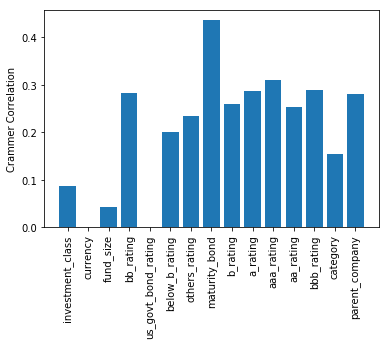

In [15]:

crammer_corr = []
for var in cat_data:
    x = cramers_v(df_root01[var], df_root01['greatstone_rating'])
    crammer_corr.append(x)

plt.bar(cat_data, crammer_corr)
plt.ylabel('Crammer Correlation')
plt.xticks(rotation=90)
plt.show()

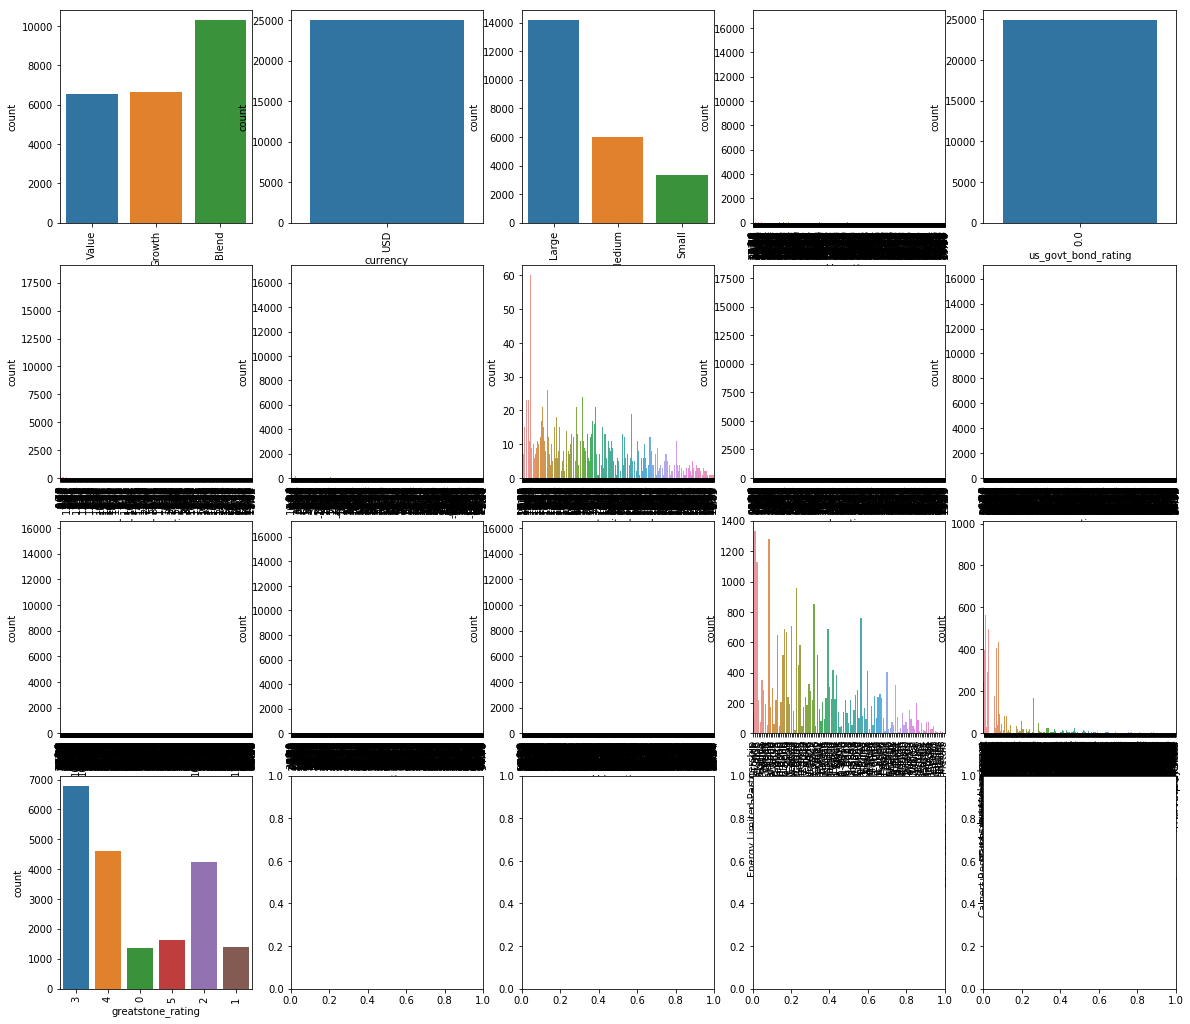

In [18]:
fig, ax = plt.subplots(4,5, figsize=(20,18))

cat_data.append('greatstone_rating')

for variable, subplot in zip(cat_data, ax.flatten()):
    sns.countplot(df_root01[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [107]:
#cat_data = ['']
cat_data = ['investment_class','fund_size','greatstone_rating','fund_id']

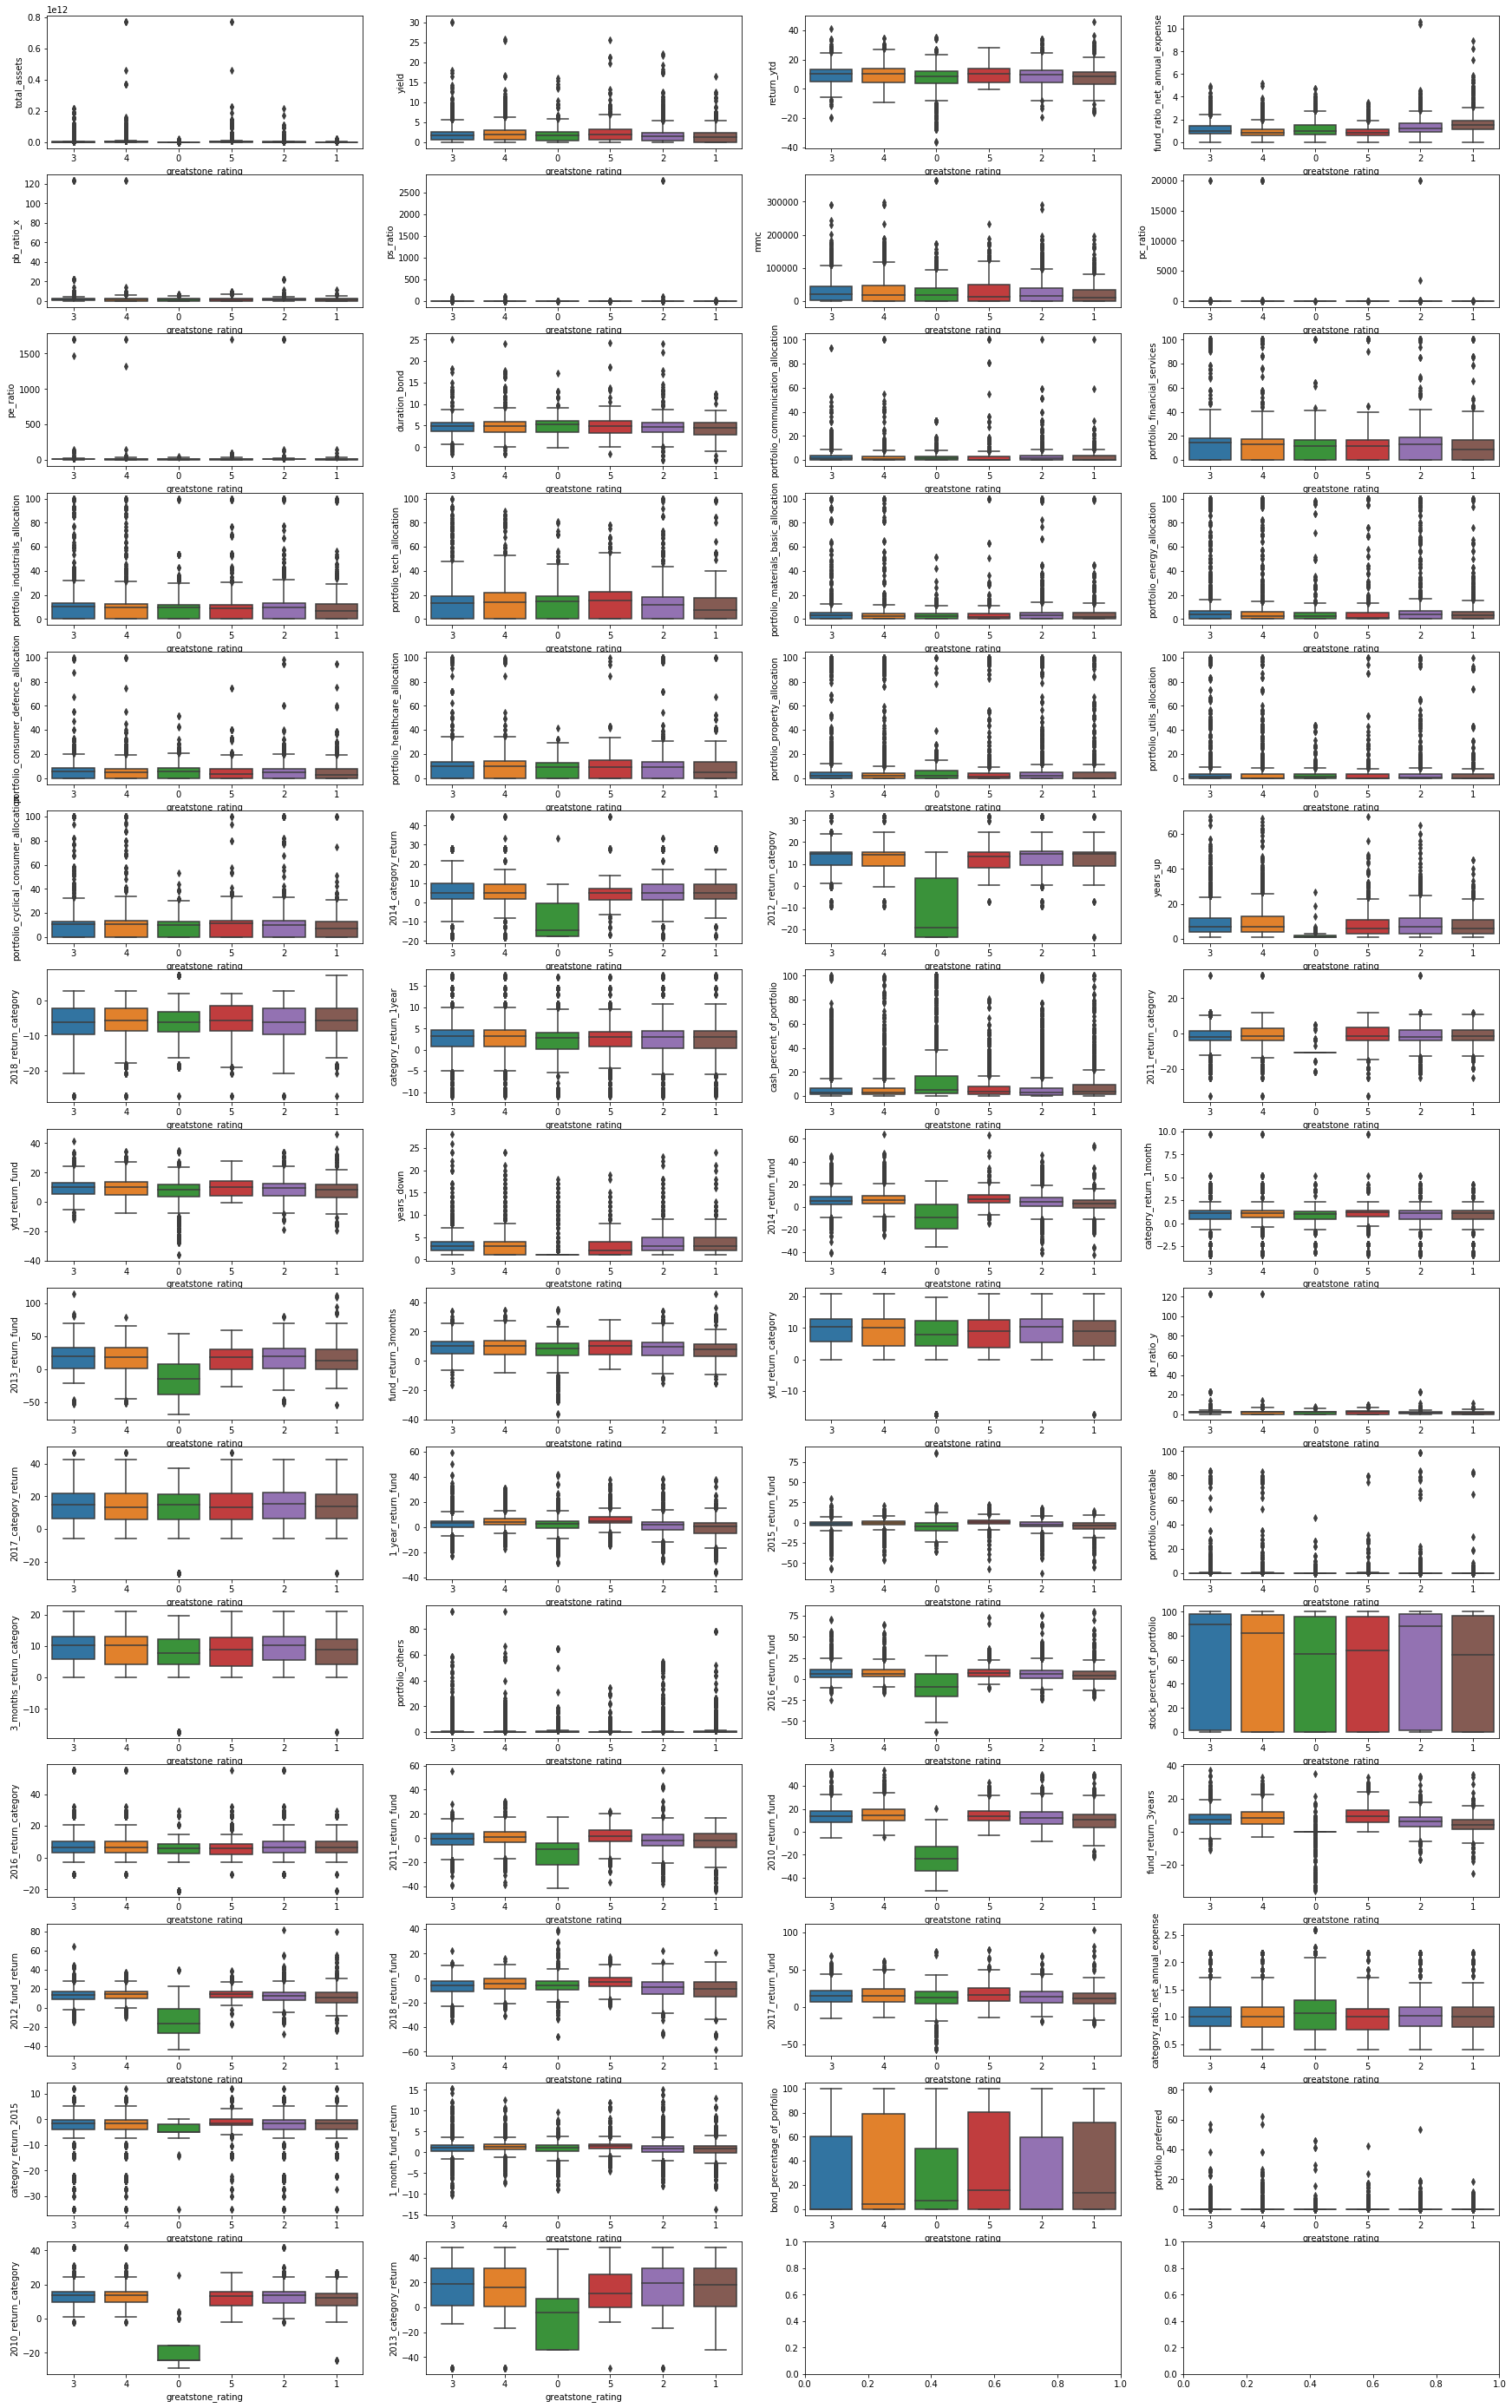

In [100]:
num_col = df_root01.select_dtypes(include='float').columns
fix, ax = plt.subplots(15,4, figsize=(30,50))

for var, subplot in zip(num_col, ax.flatten()):
    sns.boxplot(x='greatstone_rating', y=var, data=df_root01, ax=subplot)

In [102]:
num_col = ['yield','return_ytd', 'fund_ratio_net_annual_expense','mmc','duration_bond','portfolio_tech_allocation',
           'portfolio_healthcare_allocation','2014_category_return','years_up',
       '2018_return_category', 'category_return_1year',
       'cash_percent_of_portfolio', '2011_return_category', 'ytd_return_fund',
       'years_down', '2014_return_fund', 'category_return_1month',
       '2013_return_fund', 'fund_return_3months', 'ytd_return_category',
       '2017_category_return', '1_year_return_fund',
       '2015_return_fund','3_months_return_category', '2016_return_fund', '2016_return_category',
        '2011_return_fund', '2010_return_fund',
       'fund_return_3years', '2012_fund_return', '2018_return_fund',
       '2017_return_fund', 'category_ratio_net_annual_expense',
       'category_return_2015', '1_month_fund_return','2010_return_category','2013_category_return']

['a', 'b', 'c', 'd']

In [145]:
### dummies

df_01 = pd.get_dummies(df_root01, columns=cat_data[:-2])

In [146]:
df_01.select_dtypes(include='object').columns

Index(['currency', 'greatstone_rating', 'inception_date', 'fund_id',
       'bb_rating', 'us_govt_bond_rating', 'below_b_rating', 'others_rating',
       'maturity_bond', 'b_rating', 'a_rating', 'aaa_rating', 'aa_rating',
       'bbb_rating', 'category', 'parent_company', 'fund_name'],
      dtype='object')

In [147]:
df_01.head()

,currency,total_assets,yield,greatstone_rating,inception_date,tag,return_ytd,fund_id,fund_ratio_net_annual_expense,pb_ratio_x,...,bond_percentage_of_porfolio,portfolio_preferred,2010_return_category,2013_category_return,investment_class_Blend,investment_class_Growth,investment_class_Value,fund_size_Large,fund_size_Medium,fund_size_Small
0,USD,1.185000e+07,5.57,NaN,2015-02-02,67922,20.19,264614c6-5ac3-4146-ba26-1674b136cb40,1.44,1.71,...,0.00,0.00,NaN,NaN,0,0,1,1,0,0
1,USD,1.397000e+10,0.42,3,2012-05-30,134783,16.79,f5ad58c2-fdea-4087-8678-e04744f89f90,0.58,5.30,...,0.00,0.00,NaN,33.92,0,1,0,1,0,0
2,USD,2.660000e+09,0.02,4,1987-08-23,61271,17.13,3c13f4ab-02c4-4ca7-a133-7e996ec5d0c4,0.99,5.40,...,0.58,0.08,15.53,33.92,0,1,0,1,0,0
3,USD,1.957000e+10,2.71,3,2005-10-24,64412,11.63,ff78bdd8-59eb-4cef-9f3c-b1baacce9554,0.52,2.23,...,0.00,0.00,13.66,31.21,0,0,1,1,0,0
4,USD,2.847000e+07,2.44,0,2016-12-12,184058,10.25,63d8406d-c525-494a-8e03-d4fc4cfcb571,0.75,2.02,...,24.97,0.02,NaN,NaN,1,0,0,1,0,0


In [148]:
## inputation for missing data
greatstone_rating = pd.to_numeric(df_01.greatstone_rating, errors='coerce')
df_01.fillna(0, inplace=True)
df_01['greatstone_rating'] = greatstone_rating

### clear sample data

df_02 = df_01[[not i for i in df_01.greatstone_rating.isnull()]]

In [149]:
### train test split
y = df_02.greatstone_rating
X = df_02.drop(['currency', 'greatstone_rating', 'inception_date', 'fund_id',
       'bb_rating', 'us_govt_bond_rating', 'below_b_rating', 'others_rating',
       'maturity_bond', 'b_rating', 'a_rating', 'aaa_rating', 'aa_rating',
       'bbb_rating', 'category', 'parent_company', 'fund_name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [150]:
y_train

6908     3.0
8967     4.0
17778    2.0
18201    5.0
18977    3.0
12927    2.0
14376    2.0
7253     5.0
8702     4.0
9361     3.0
8460     5.0
12096    4.0
12995    1.0
12663    4.0
4645     1.0
6335     4.0
6144     4.0
21533    3.0
16315    4.0
10750    1.0
22526    1.0
14495    1.0
16366    5.0
11561    1.0
5986     2.0
4606     0.0
581      2.0
11081    2.0
8905     0.0
14710    0.0
        ... 
22682    3.0
11311    4.0
18989    2.0
17092    2.0
2356     3.0
16779    2.0
1095     0.0
17858    3.0
11544    0.0
6307     1.0
4969     3.0
5153     3.0
13436    4.0
18675    3.0
10725    5.0
17980    5.0
22535    2.0
20918    3.0
22261    3.0
18423    4.0
21705    4.0
24217    2.0
3518     2.0
23060    3.0
22762    2.0
16051    3.0
22569    0.0
6196     3.0
8149     5.0
18736    2.0
Name: greatstone_rating, Length: 16000, dtype: float64

In [151]:
X_train.shape

(16000, 66)

In [152]:
X_test.shape

(4000, 66)

In [156]:
### random forest
rfcl = RandomForestClassifier(n_estimators = 500, random_state=1,max_features=60)
rfcl = rfcl.fit(X_train, y_train)

y_predict = rfcl.predict(X_test)

print('Accuracy of the model:', metrics.accuracy_score(y_test, y_predict))


Accuracy of the model: 0.7385


In [158]:
#### Predict Final

df_sample_submission2 = pd.merge(df_01, df_sample_submission, how='inner', left_on='fund_id', right_on='fund_id')
df_sample_submission2.shape

(5000, 84)

Index(['total_assets', 'yield', 'tag', 'return_ytd',
       'fund_ratio_net_annual_expense', 'pb_ratio_x', 'ps_ratio', 'mmc',
       'pc_ratio', 'pe_ratio', 'duration_bond',
       'portfolio_communication_allocation', 'portfolio_financial_services',
       'portfolio_industrials_allocation', 'portfolio_tech_allocation',
       'portfolio_materials_basic_allocation', 'portfolio_energy_allocation',
       'portfolio_consumer_defence_allocation',
       'portfolio_healthcare_allocation', 'portfolio_property_allocation',
       'id', 'portfolio_utils_allocation',
       'portfolio_cyclical_consumer_allocation', '2014_category_return',
       '2012_return_category', 'years_up', '2018_return_category',
       'category_return_1year', 'cash_percent_of_portfolio',
       '2011_return_category', 'ytd_return_fund', 'years_down',
       '2014_return_fund', 'category_return_1month', '2013_return_fund',
       'fund_return_3months', 'ytd_return_category', 'pb_ratio_y',
       '2017_category_return

In [161]:
predict_final = rfcl.predict(df_sample_submission2[X_train.columns])

In [162]:
predict_final

array([2., 4., 2., ..., 3., 2., 2.])

In [163]:
df_sample_submission['greatstone_rating'] = predict_final
df_sample_submission.head()

,fund_id,greatstone_rating
0,85a6edf9-db47-490c-981a-168ce90434bb,2.0
1,654dac08-5e5d-4cf0-870e-3167087de7d2,4.0
2,75214019-f876-42a9-a316-328b759ac4ba,2.0
3,1fe8de6d-cd33-489e-a829-211f1f622eed,3.0
4,bd87a7a0-6ca5-4607-a0cf-d396ecd6037a,3.0


In [164]:
df_sample_submission.to_csv('reinaldo_maciel01.csv')